# Assignment #1: River Basin Tradeoff Analysis and Vulnerability Analysis
Ryan Tan, Ludwig Branzk, Ariel Goldin

For this assignment, you will generate a tradeoff analysis across the different actors and water uses of the Nile basin for a set of Pareto optimal operating policies for the reservoirs located in Ethiopia, Sudan and Egypt.  Further, we will identify the key factors affecting the success of failure to meet the demands, providing information about the vulnerability of the system.

In [15]:
# Importing required packages
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from tqdm import tqdm
from IPython.display import Image

# We need to give permission for connecting to our drive files
#from google.colab import drive
#drive.mount('/content/drive')
# Copying the files from our drive folder. The folder name after ../MyDrive/ must match
#!cp /content/drive/MyDrive/water_systems -r /content

from water_systems.model_nile import ModelNile
from water_systems import plotter

## Nile River Basin model

In this case, we apply the modeling approach used by [Sari et.al. 2022](https://repository.tudelft.nl/islandora/object/uuid%3Aba09fa13-5331-446c-bf5e-48f6a29042ca?collection=education).  The problem, however, can be framed differently depending on the perspective of a country or a group of stakeholders. From Egypt's and Sudan's perspective, the goal is to minimize water shortages, whereas for Ethiopia, the priority is to maximize hydropower generation from the GERD. Therefore, no single objective formulation can maximize performance across all actors.  Due to the conflicting interests of the three countries, we use a many objective optimization problem formulation to find the **Pareto-optimal set**, where one objective cannot improve performance without degrading performance in one or more objectives.  

We define six objectives for the problem:

* Minimize average annual water shortage for Egypt and for Sudan during the
simulation horizon of 2022-2042.

*  Minimize the deficit of a month with the 90$^{th}$ percentile worst deficit. This objective denotes high risk aversion by minimizing the deficit for a catastrophic month for Sudan and Egypt.
* Minimize the frequency of months when the water level in the High Aswan Dam (HAD) falls below the minimum hydroenergy production level. This objective reflects Egypt's hydropower generation goals.
* Maximize hydropower production Ethiopia desires to maximize the hydroenergy they produced from the GERD. Objectives are summarised in the table below.


Country  | Objective     |Aggregation level| Unit    |Direction|
---------|---------------|-----------------|---------|---------|
Egypt    | Demand deficit| Annual average  | BCM/year|minimize |
Egypt    | Demand deficit| 90th percentile worst month|BCM/month|minimize
Egypt    | HAD level reliability| Frequency over 20 years| percent | minimize|
Sudan|Demand deficit| Annual average|BCM/month|minimize|
Sudan|Demand deficit| 90 th percentile worst month| BCM/month| minimize|
Ethiopia| Hydropower generation|Annual average|TWh/year|maximize|


To find the mult-reservoir, multi-objective control policy for the Nile system, we use **Evolutionary Multi-objective Direct Policy Search [(EMODPS)](https://ascelibrary.org/doi/10.1061/%28ASCE%29WR.1943-5452.0000570)** due to its flexibility to simultaneously find policies across many objectives, and its ability to overcome the dimensionality issues encountered when adding more states to the system (*i.e.* multiple reservoirs and streamflow scenarios). We first parameterize the control policy via nonlinear approximators, in this case, we use radial basis functions, due to their flexibility to find the control policy for multiple objectives.  The parameters of the radial basis functions are then optimized using a multiobjective evolutionary algorithm (MOEA) based on their performance across all the objectives of the system.  

A weighted Gaussian RBF is used to parameterize the release policy below.

\begin{align}
        u^k_{τ} = u^k_{\theta}(Z_{\tau})\sum_{i=1} w_i^k\phi(Z_{\tau})
\end{align}

where $u_{\tau}^k$ is the $k^{th}$ release decision at month $\tau$ and $\theta$ is the parameter vector for the RBFs defined as $\theta=|c_{i,j}, b_{i,j}, w_i^k|$, indicating the center, radius and weight of the $i^{th}$ RBF, $\bar{z}_{\tau}$ is the input vector such that $\bar{z}_{tau}=|z_{\tau, 1},..., z_{\tau, m}|$.  The calculation of a single Gaussian RBF is shown in the equation below:


\begin{align}
        𝜑(\bar{Z}_{\tau})= exp(-\sum_{j=1}^m\frac{(z_{\tau,j}-c_{j,i})^2}{b^2_{j,i}})
\end{align}

 A visual summary of the EMODPS methodology within the [XLRM framework](https://www.rand.org/pubs/monograph_reports/MR1626.html) is provided below.

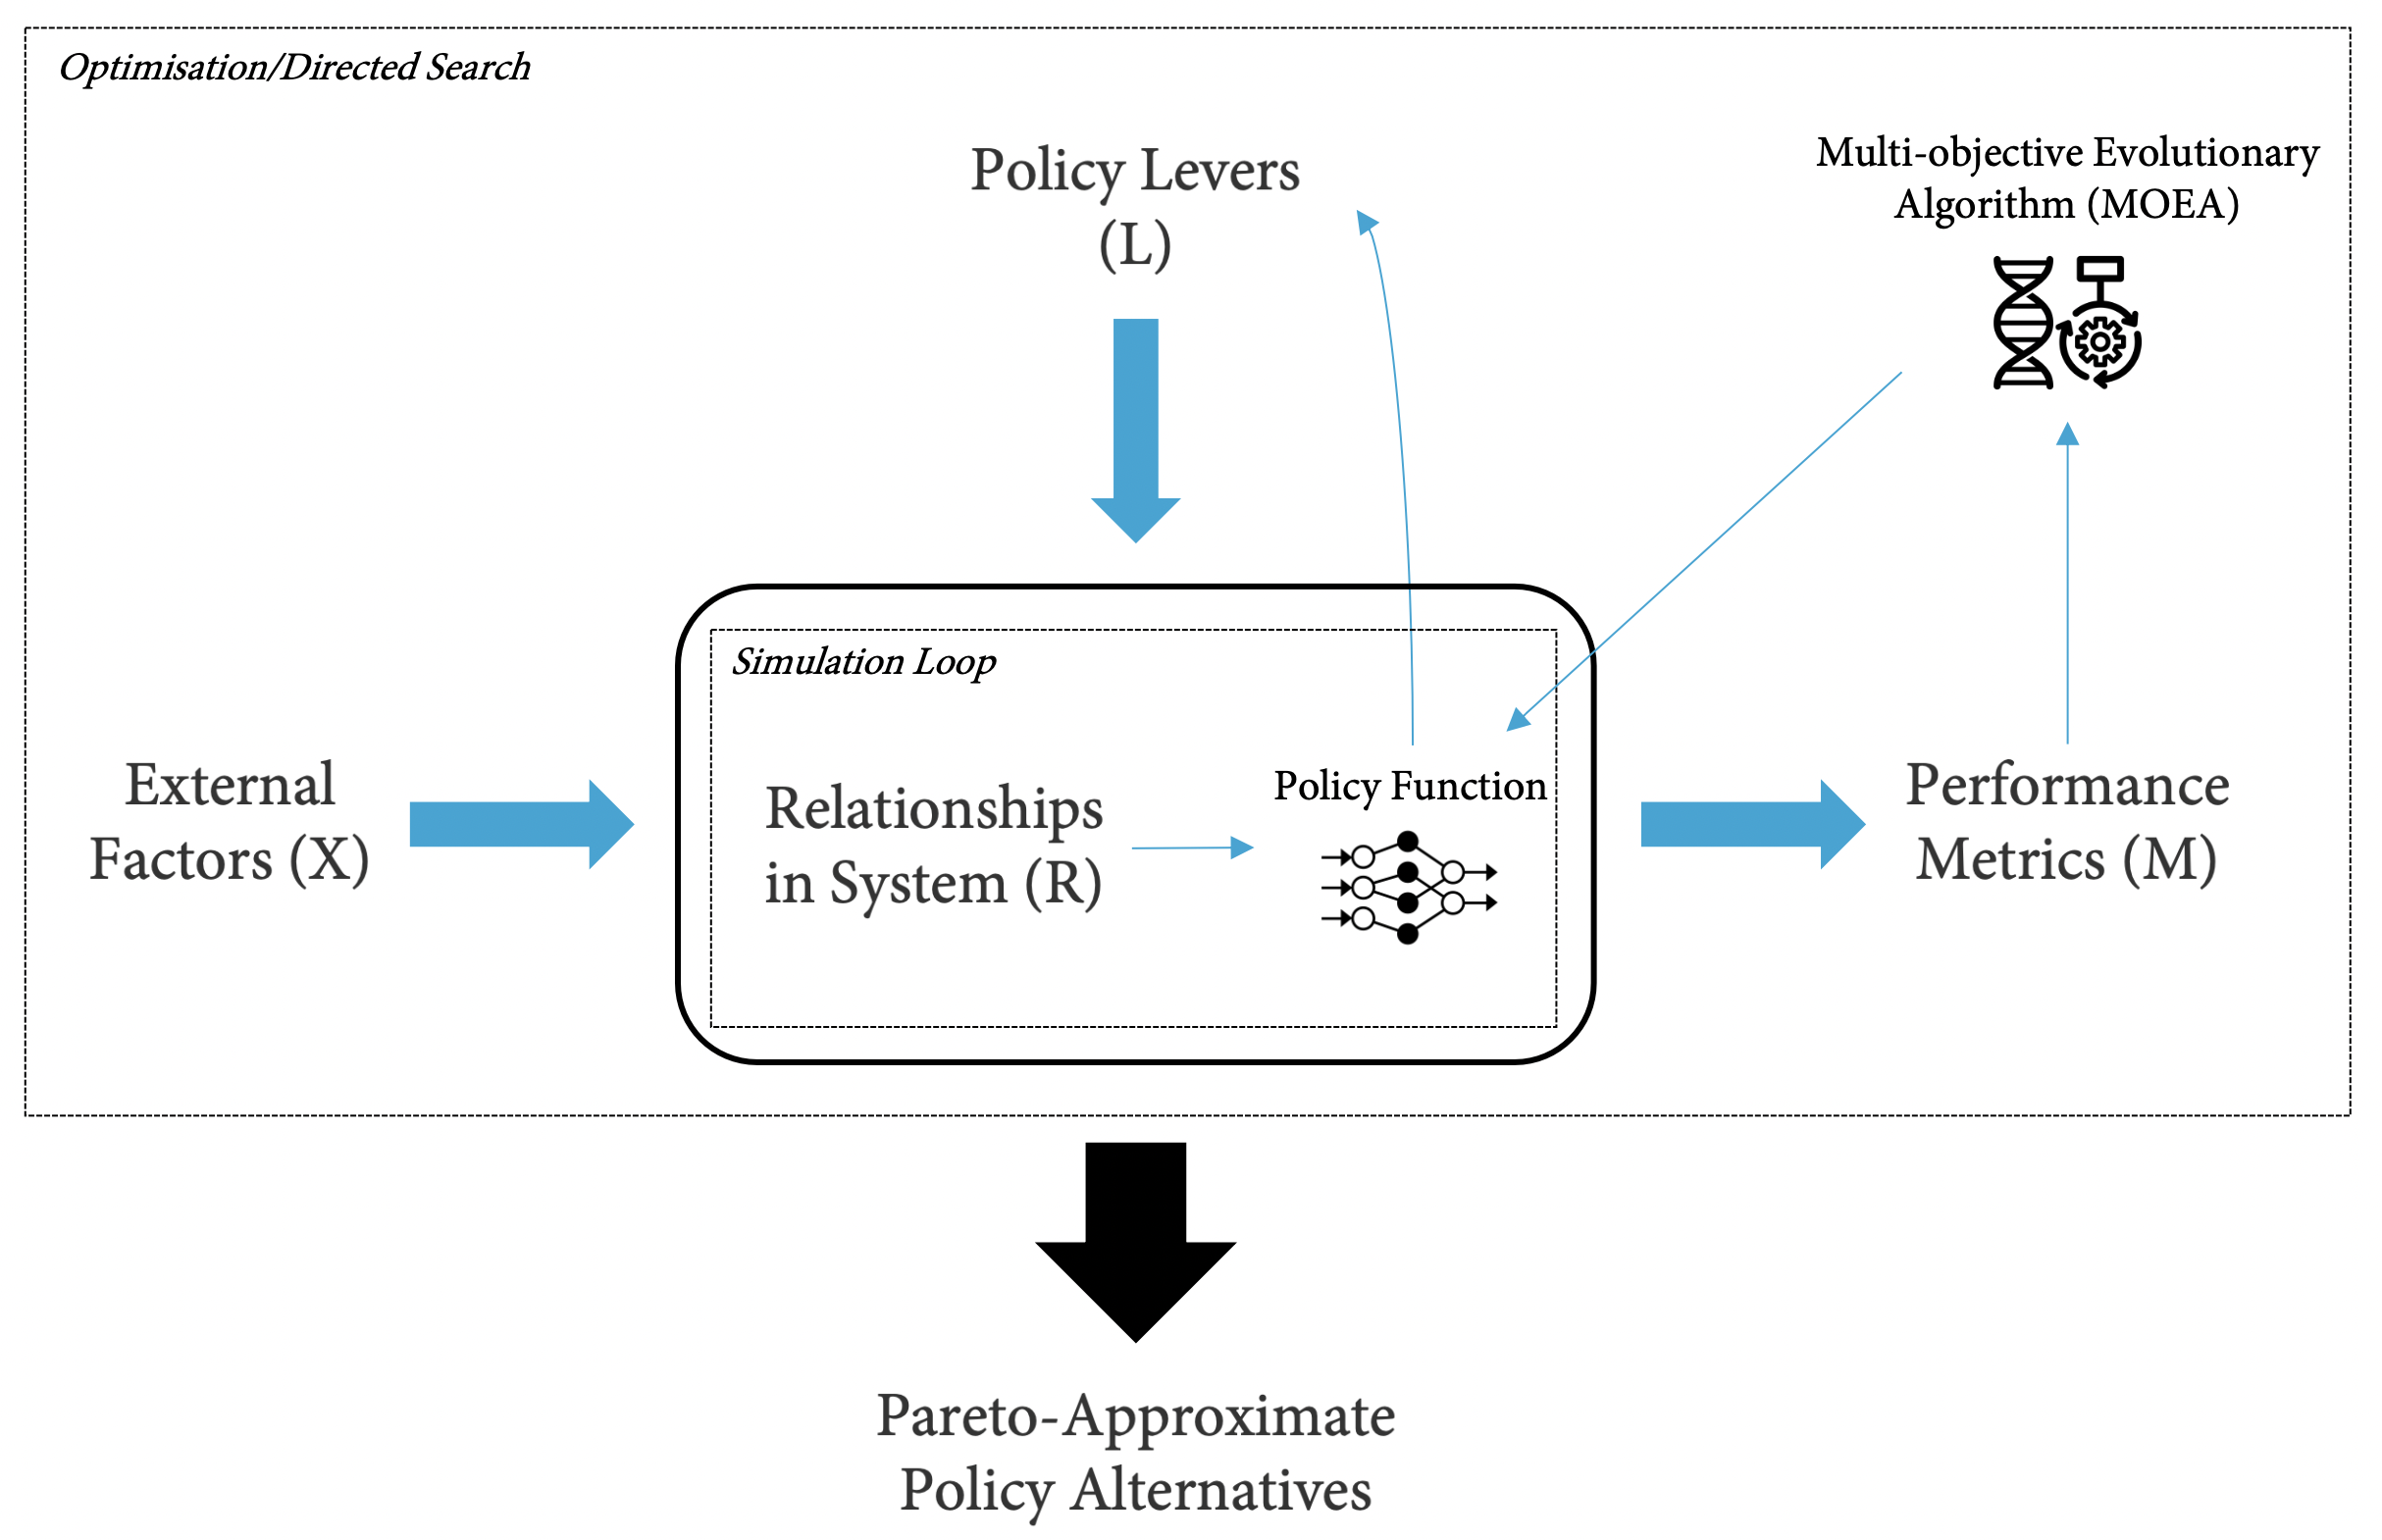

In [16]:
Image(filename='water_systems/readme_images/EMODPS_summary.png')

##Pareto optimal tradeoffs across multiple conflicting water uses in the Nile River Basin

By running the code snipet below you will find the Pareto-optimal set of solutions. The dataframe is organized in columns which include the decision variables (values assigned to free parameters of the policy function) and the last six columns of the dataframe are the corresponding objective values.  Each row in the dataframe is a different Pareto-optimal policy.

In [17]:
opt_results = pd.read_csv("water_systems/baseline_results.csv").drop(columns="Unnamed: 0")
opt_results.head()

,v0,v1,v2,v3,v4,v5,v6,v7,v8,v9,...,v160,v161,v162,v163,egypt_irr,egypt_90,egypt_low_had,sudan_irr,sudan_90,ethiopia_hydro
0,0.082993,0.811609,0.463100,0.292359,0.279911,0.848383,-0.595641,0.134243,0.325801,0.030051,...,0.598760,0.617328,0.903964,0.063729,6.687976,1.525420,0.004167,0.002289,0.000000,14.640650
1,0.015787,0.809545,0.927957,0.311354,0.286745,0.854163,-0.590347,0.464409,0.317463,0.029033,...,0.189810,0.618542,0.269902,0.871519,3.130912,0.747328,0.183333,0.952067,0.234347,12.567715
2,0.082993,0.811609,0.946431,0.292359,0.279911,0.848383,-0.586181,0.134243,0.325801,0.030051,...,0.598760,0.617328,0.903964,0.063729,6.128643,1.496204,0.029167,0.000000,0.000000,14.625402
3,0.014471,0.803036,0.949657,0.311288,0.275820,0.848383,-0.627287,0.167977,0.291462,0.100378,...,0.183201,0.618279,0.924576,0.141372,5.468128,1.075512,0.708333,0.185484,0.000000,15.002676
4,0.015787,0.869487,0.943521,0.311354,0.286745,0.856220,-0.590347,0.585532,0.317463,0.029033,...,0.189810,0.618542,0.270329,0.883693,5.128414,1.574623,0.004167,0.762147,0.000000,14.007736


We first split the results into policies and objective using the code below. Further, we inspect the summary statistics across objectives, using objectives.describe().

In [18]:
policies, objectives = opt_results.iloc[:, :-6], opt_results.iloc[:, -6:]
objectives.columns = [
        "Egypt Irr. Deficit",
        "Egypt 90th Irr. Deficit",
        "Egypt Low HAD",
        "Sudan Irr. Deficit",
        "Sudan 90th Irr. Deficit",
        "Ethiopia Hydropower"
]
objectives.describe()

,Egypt Irr. Deficit,Egypt 90th Irr. Deficit,Egypt Low HAD,Sudan Irr. Deficit,Sudan 90th Irr. Deficit,Ethiopia Hydropower
count,1140.000000,1140.000000,1140.000000,1140.000000,1140.000000,1140.000000
mean,3.983717,0.978327,0.257920,0.527701,0.104980,13.466072
std,1.082543,0.341012,0.223281,0.572047,0.256392,1.230052
min,1.785302,0.151996,0.000000,0.000000,0.000000,9.783139
25%,3.168426,0.719622,0.075000,0.110130,0.000000,12.783826
50%,3.798724,0.968214,0.191667,0.254711,0.000000,13.666322
75%,4.591378,1.220168,0.396875,0.841442,0.000000,14.447477
max,11.995087,3.089898,0.795833,3.244097,1.502507,15.222886


A popular visualization strategy for  trade-off analysis across many objectives are [parallel coordinates](https://ieeexplore.ieee.org/document/636793). With parallel coordinates, each vertical axis represents the values for a particular objective.  The direction of preference is fixed across all objectives such that a line on top of all axis would represent the 'ideal' solution.  If two lines cross, it indicates that a tradeoff was encountered, in other words, it denotes high performance in one objective and low performance in another objective.   

The code below generates the parallel coordinates for the objective values. This function is called with the objectives dataframe.

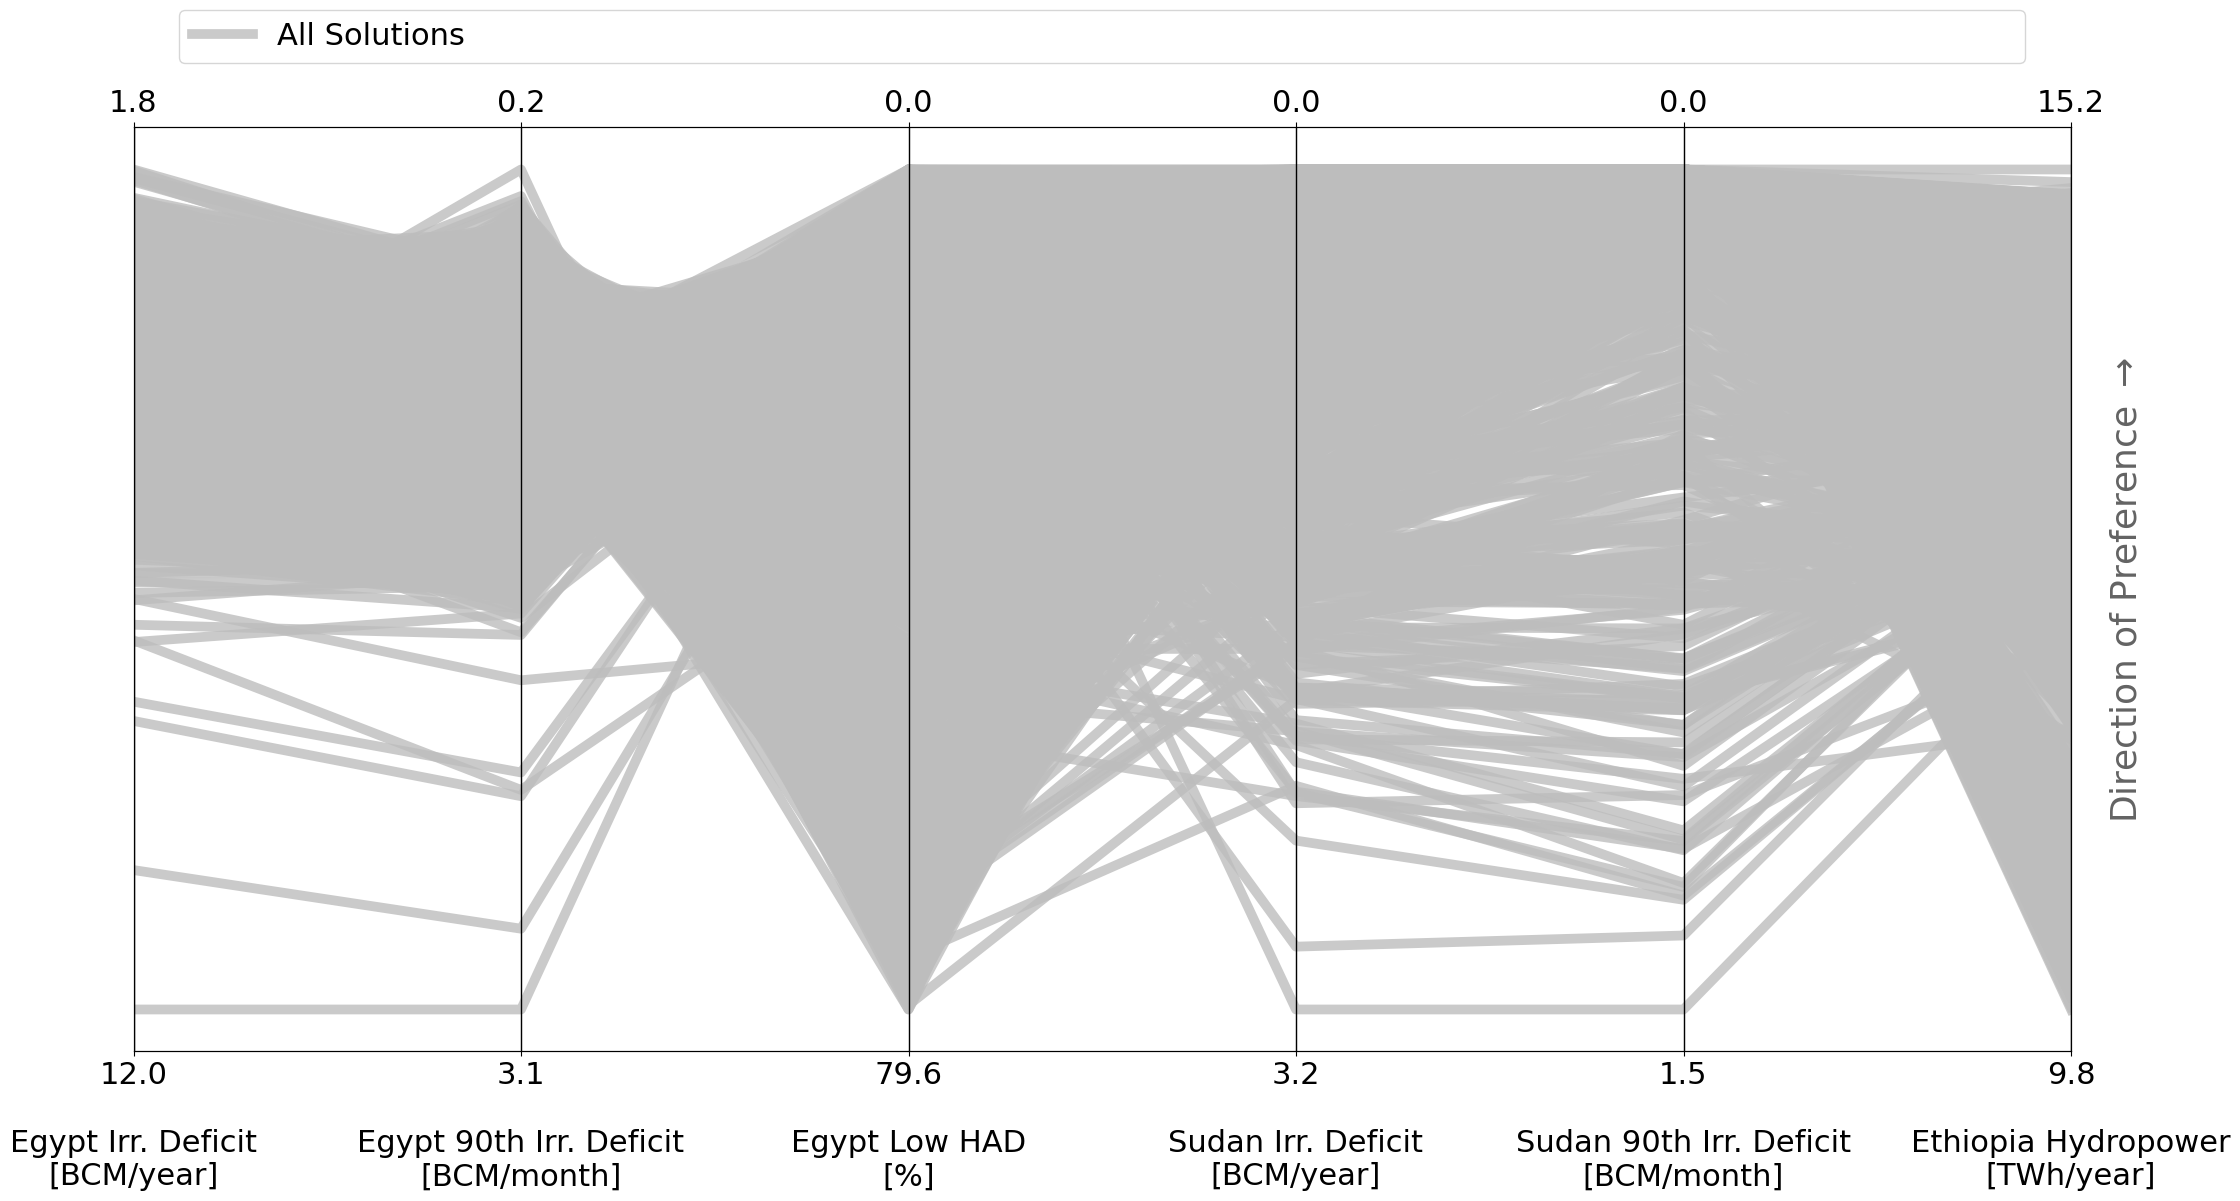

In [19]:
from water_systems.plotter import parallel_plots_many_policies

parallel_plots_many_policies(
    objectives,
    solution_indices=[],
    solution_names = []
)
plt.show()

## Task 1. Selecting and Analyzing Policies from the Pareto-optimal Set

Find the policies that yield the best performance across each of the Nile system's objectives (minimum value for minimization objectives and maximum value for maximization objectives). Give self-explanatory names to these policies and color-code them in the parallel coordinates plot.

Reflect on your findings and what they mean for the trade-offs between objectives.

Tip:  To color-code specific policies from the Pareto-optimal set note that we have two empty lists as arguments for the parallel_plots_many_policies *solution_indices* and *solution_names*. It is possible to use these arguments to color-code the selected policies. For instance, the policy with index 100 is color-coded below.

In [20]:
objectives.describe()

,Egypt Irr. Deficit,Egypt 90th Irr. Deficit,Egypt Low HAD,Sudan Irr. Deficit,Sudan 90th Irr. Deficit,Ethiopia Hydropower
count,1140.000000,1140.000000,1140.000000,1140.000000,1140.000000,1140.000000
mean,3.983717,0.978327,0.257920,0.527701,0.104980,13.466072
std,1.082543,0.341012,0.223281,0.572047,0.256392,1.230052
min,1.785302,0.151996,0.000000,0.000000,0.000000,9.783139
25%,3.168426,0.719622,0.075000,0.110130,0.000000,12.783826
50%,3.798724,0.968214,0.191667,0.254711,0.000000,13.666322
75%,4.591378,1.220168,0.396875,0.841442,0.000000,14.447477
max,11.995087,3.089898,0.795833,3.244097,1.502507,15.222886


In finding a pareto-optimal set (from most ideal policy per each objective), we noticed the optimal policy for "Sudan Irr. Deficit"	and "Sudan 90th Irr. Deficit" can be combined since they both have multiple policies with the most desirable value of 0.

In [21]:
# Best Policies by Objectives
min_egy_irr_def = objectives['Egypt Irr. Deficit'].idxmin()
min_egy_90_irr_def = objectives['Egypt 90th Irr. Deficit'].idxmin()
min_egy_low = objectives['Egypt Low HAD'].idxmin()
min_sud_irr_def = objectives['Sudan Irr. Deficit'].idxmin()
min_sud_90_irr_def = objectives['Sudan 90th Irr. Deficit'].idxmin()
max_eth_hyd = objectives['Ethiopia Hydropower'].idxmax()

# Best Policies by Country's Interests
best_egy = objectives.nsmallest(1, ['Egypt Irr. Deficit', 'Egypt 90th Irr. Deficit', 'Egypt Low HAD']).index[0]
best_sud = objectives.nsmallest(1, ['Sudan 90th Irr. Deficit', 'Sudan Irr. Deficit']).index[0]
best_eth = max_eth_hyd

In [22]:
# Check for repetition of pareto set

[min_egy_irr_def,
min_egy_90_irr_def,
min_egy_low,
min_sud_irr_def,
min_sud_90_irr_def,
max_eth_hyd]

[1019, 661, 10, 2, 0, 740]

### Best Policies by Individual Policies

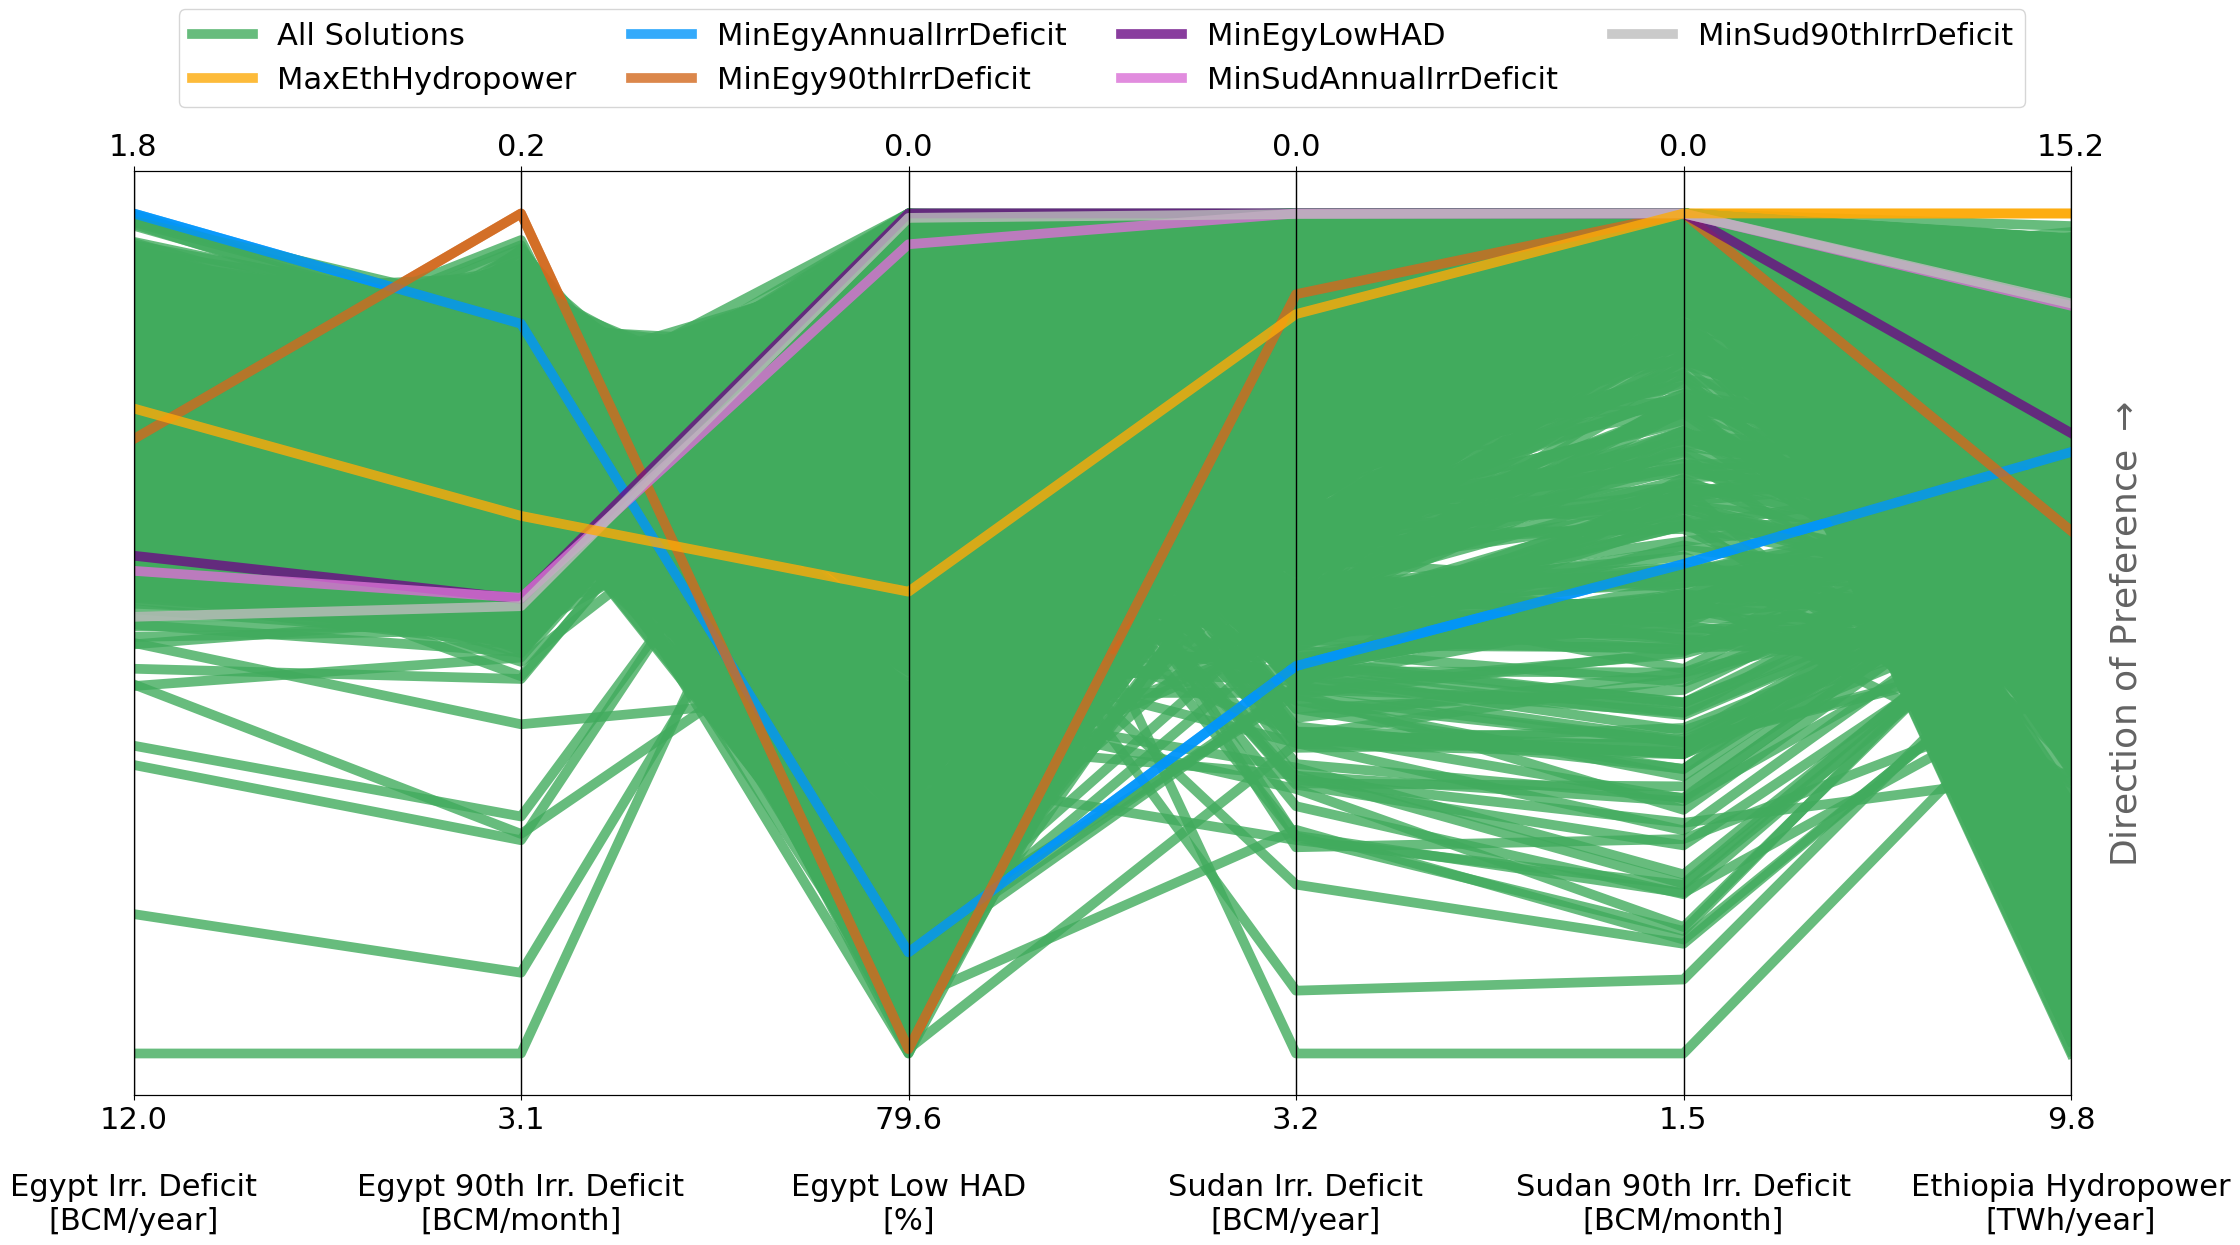

In [23]:
paretoset_indices = [min_egy_irr_def,
                    min_egy_90_irr_def,
                    min_egy_low,
                    min_sud_irr_def,
                    min_sud_90_irr_def,
                    max_eth_hyd]

paretoset_names = ['MinEgyAnnualIrrDeficit',
                    'MinEgy90thIrrDeficit',
                    'MinEgyLowHAD',
                    'MinSudAnnualIrrDeficit',
                    'MinSud90thIrrDeficit',
                    'MaxEthHydropower']


parallel_plots_many_policies(
    objectives,
    solution_indices = paretoset_indices,
    solution_names = paretoset_names 
)
plt.show()

Tradeoffs in Objectives


### Best Policies by Country's interests

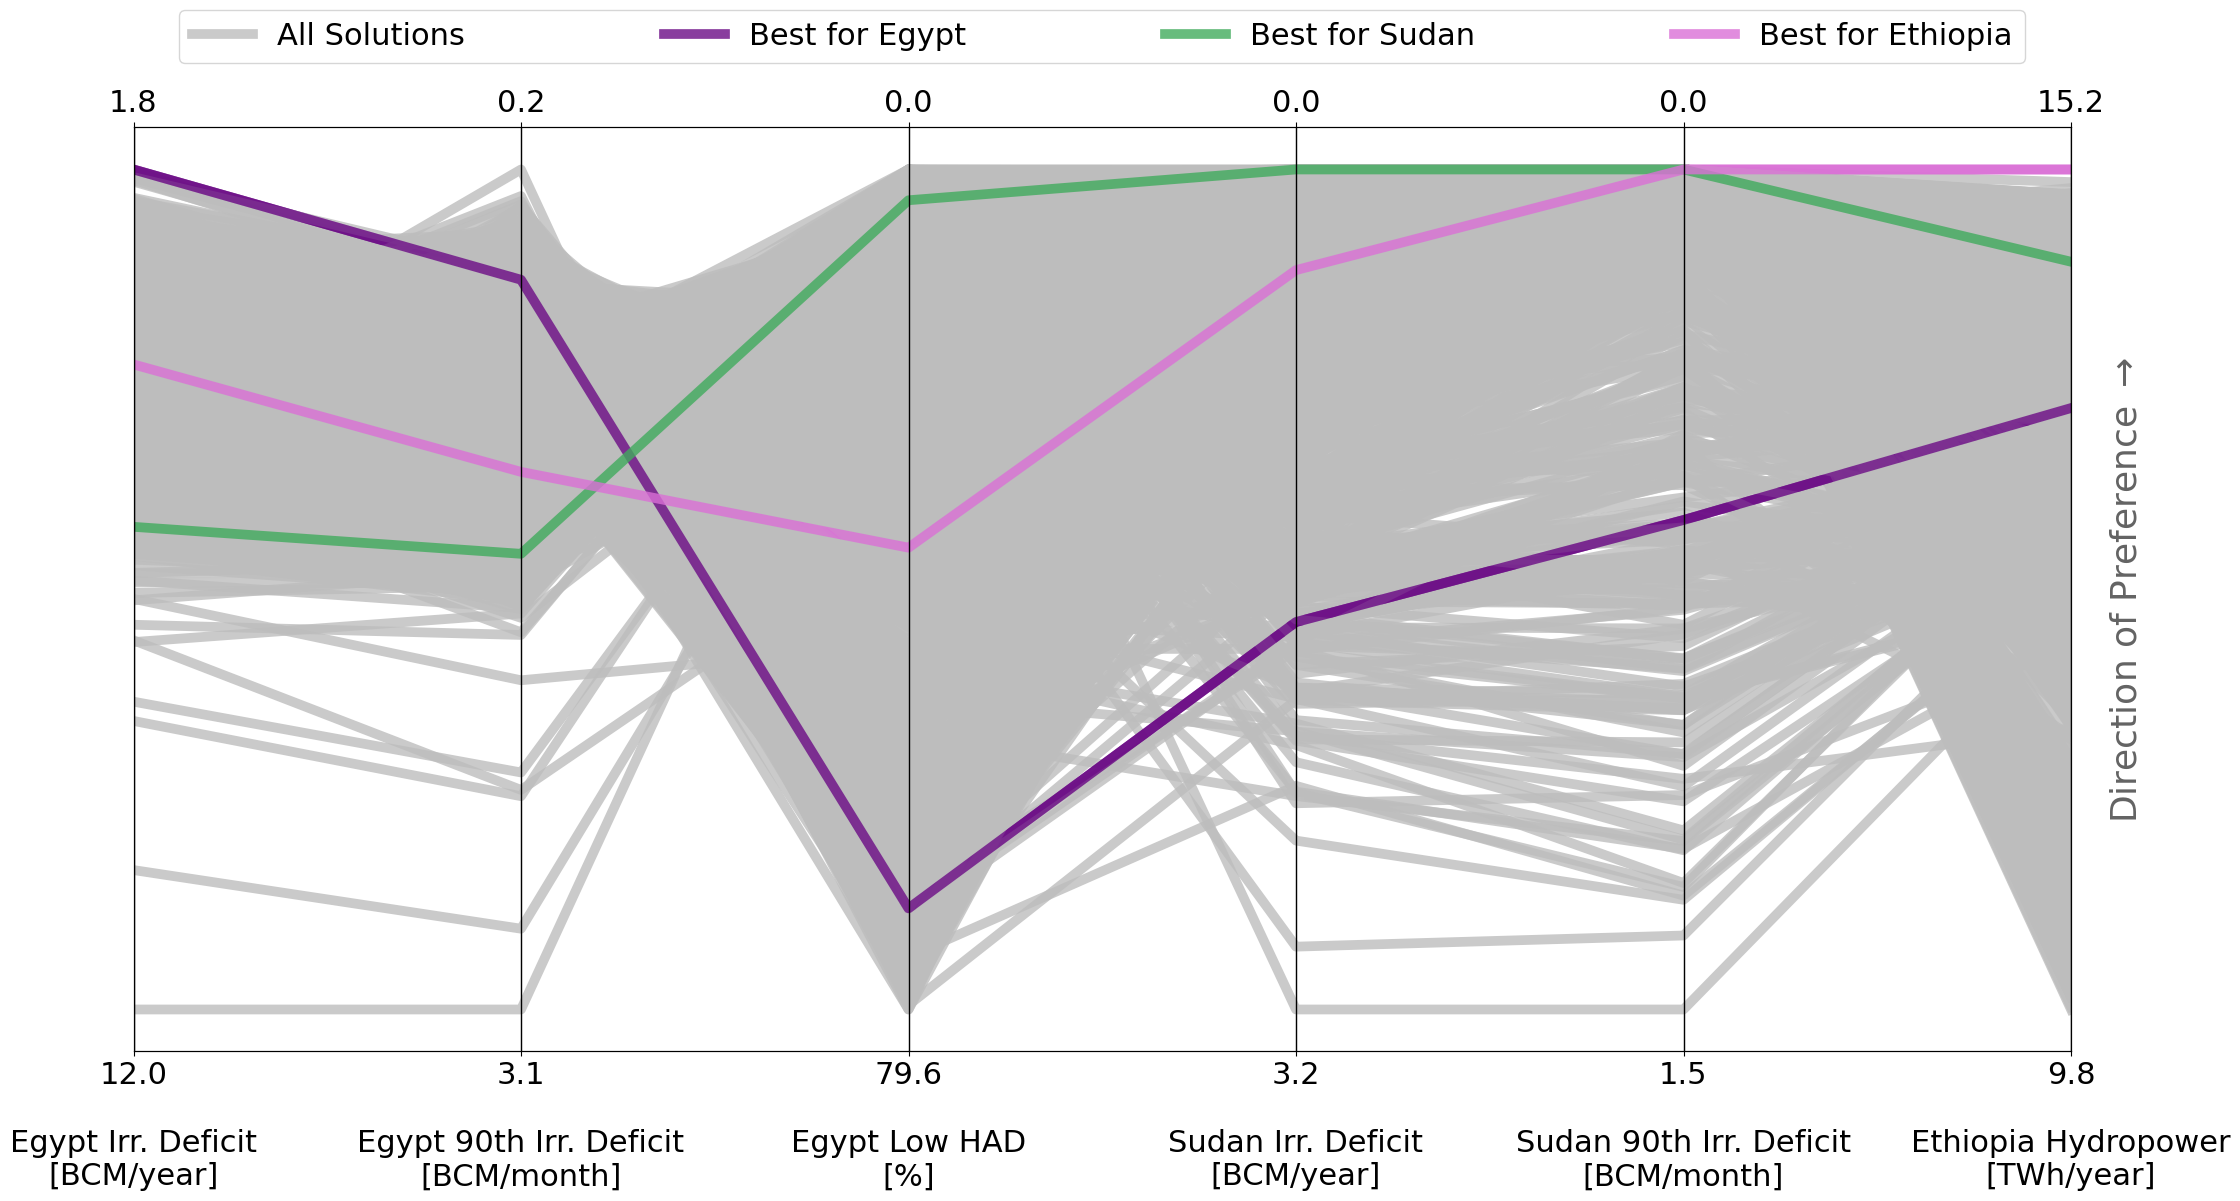

In [24]:
parallel_plots_many_policies(
    objectives,
    solution_indices = [best_egy,
                        best_sud,
                        best_eth],
    solution_names = ["Best for Egypt",
                      "Best for Sudan",
                      "Best for Ethiopia"])

plt.show()

## Task 2. Defining compromise solutions across the system's objectives


Define two compromise solutions, this could be done by setting reliability thresholds across the different objectives. Please justify your selection.

Plot these solutions along with the best policies across each objective.  Provide the parallel coordinates that include the full set of policies with the eight highlighted policies (*i.e.* the best performance across the six objectives and the two compromise solutions). You can use the code below to save your solutions as a csv file.



In [25]:
objectives.describe()

,Egypt Irr. Deficit,Egypt 90th Irr. Deficit,Egypt Low HAD,Sudan Irr. Deficit,Sudan 90th Irr. Deficit,Ethiopia Hydropower
count,1140.000000,1140.000000,1140.000000,1140.000000,1140.000000,1140.000000
mean,3.983717,0.978327,0.257920,0.527701,0.104980,13.466072
std,1.082543,0.341012,0.223281,0.572047,0.256392,1.230052
min,1.785302,0.151996,0.000000,0.000000,0.000000,9.783139
25%,3.168426,0.719622,0.075000,0.110130,0.000000,12.783826
50%,3.798724,0.968214,0.191667,0.254711,0.000000,13.666322
75%,4.591378,1.220168,0.396875,0.841442,0.000000,14.447477
max,11.995087,3.089898,0.795833,3.244097,1.502507,15.222886


In [26]:
# Calculate a threshold
x = 0.54

# all factor below a certain 
quantile_threshold = objectives.quantile(x) 
ethiopia_threshold = objectives['Ethiopia Hydropower'].quantile(1-x)

# Use boolean indexing to extract rows within the top 80% for each column
objectives_filtered = objectives[(objectives['Egypt Irr. Deficit'] <= quantile_threshold['Egypt Irr. Deficit']) &
                        (objectives['Egypt 90th Irr. Deficit'] <= quantile_threshold['Egypt 90th Irr. Deficit']) &
                        (objectives['Egypt Low HAD'] <= quantile_threshold['Egypt Low HAD']) &
                        (objectives['Sudan Irr. Deficit'] <= quantile_threshold['Sudan Irr. Deficit']) &
                        (objectives['Sudan 90th Irr. Deficit'] <= quantile_threshold['Sudan 90th Irr. Deficit']) &
                        (objectives['Ethiopia Hydropower'] >= ethiopia_threshold ) 
                        ]

objectives_filtered

,Egypt Irr. Deficit,Egypt 90th Irr. Deficit,Egypt Low HAD,Sudan Irr. Deficit,Sudan 90th Irr. Deficit,Ethiopia Hydropower
907,3.879475,0.96001,0.195833,0.226105,0.0,13.826642
921,3.724210,1.00112,0.112500,0.073672,0.0,13.570897


In [27]:
solution_indices = objectives_filtered.index.tolist() # Input the indices for your policy selection 
solution_names = ["policy" + str(index) for index in solution_indices] # Input explanatory names for your policy selection

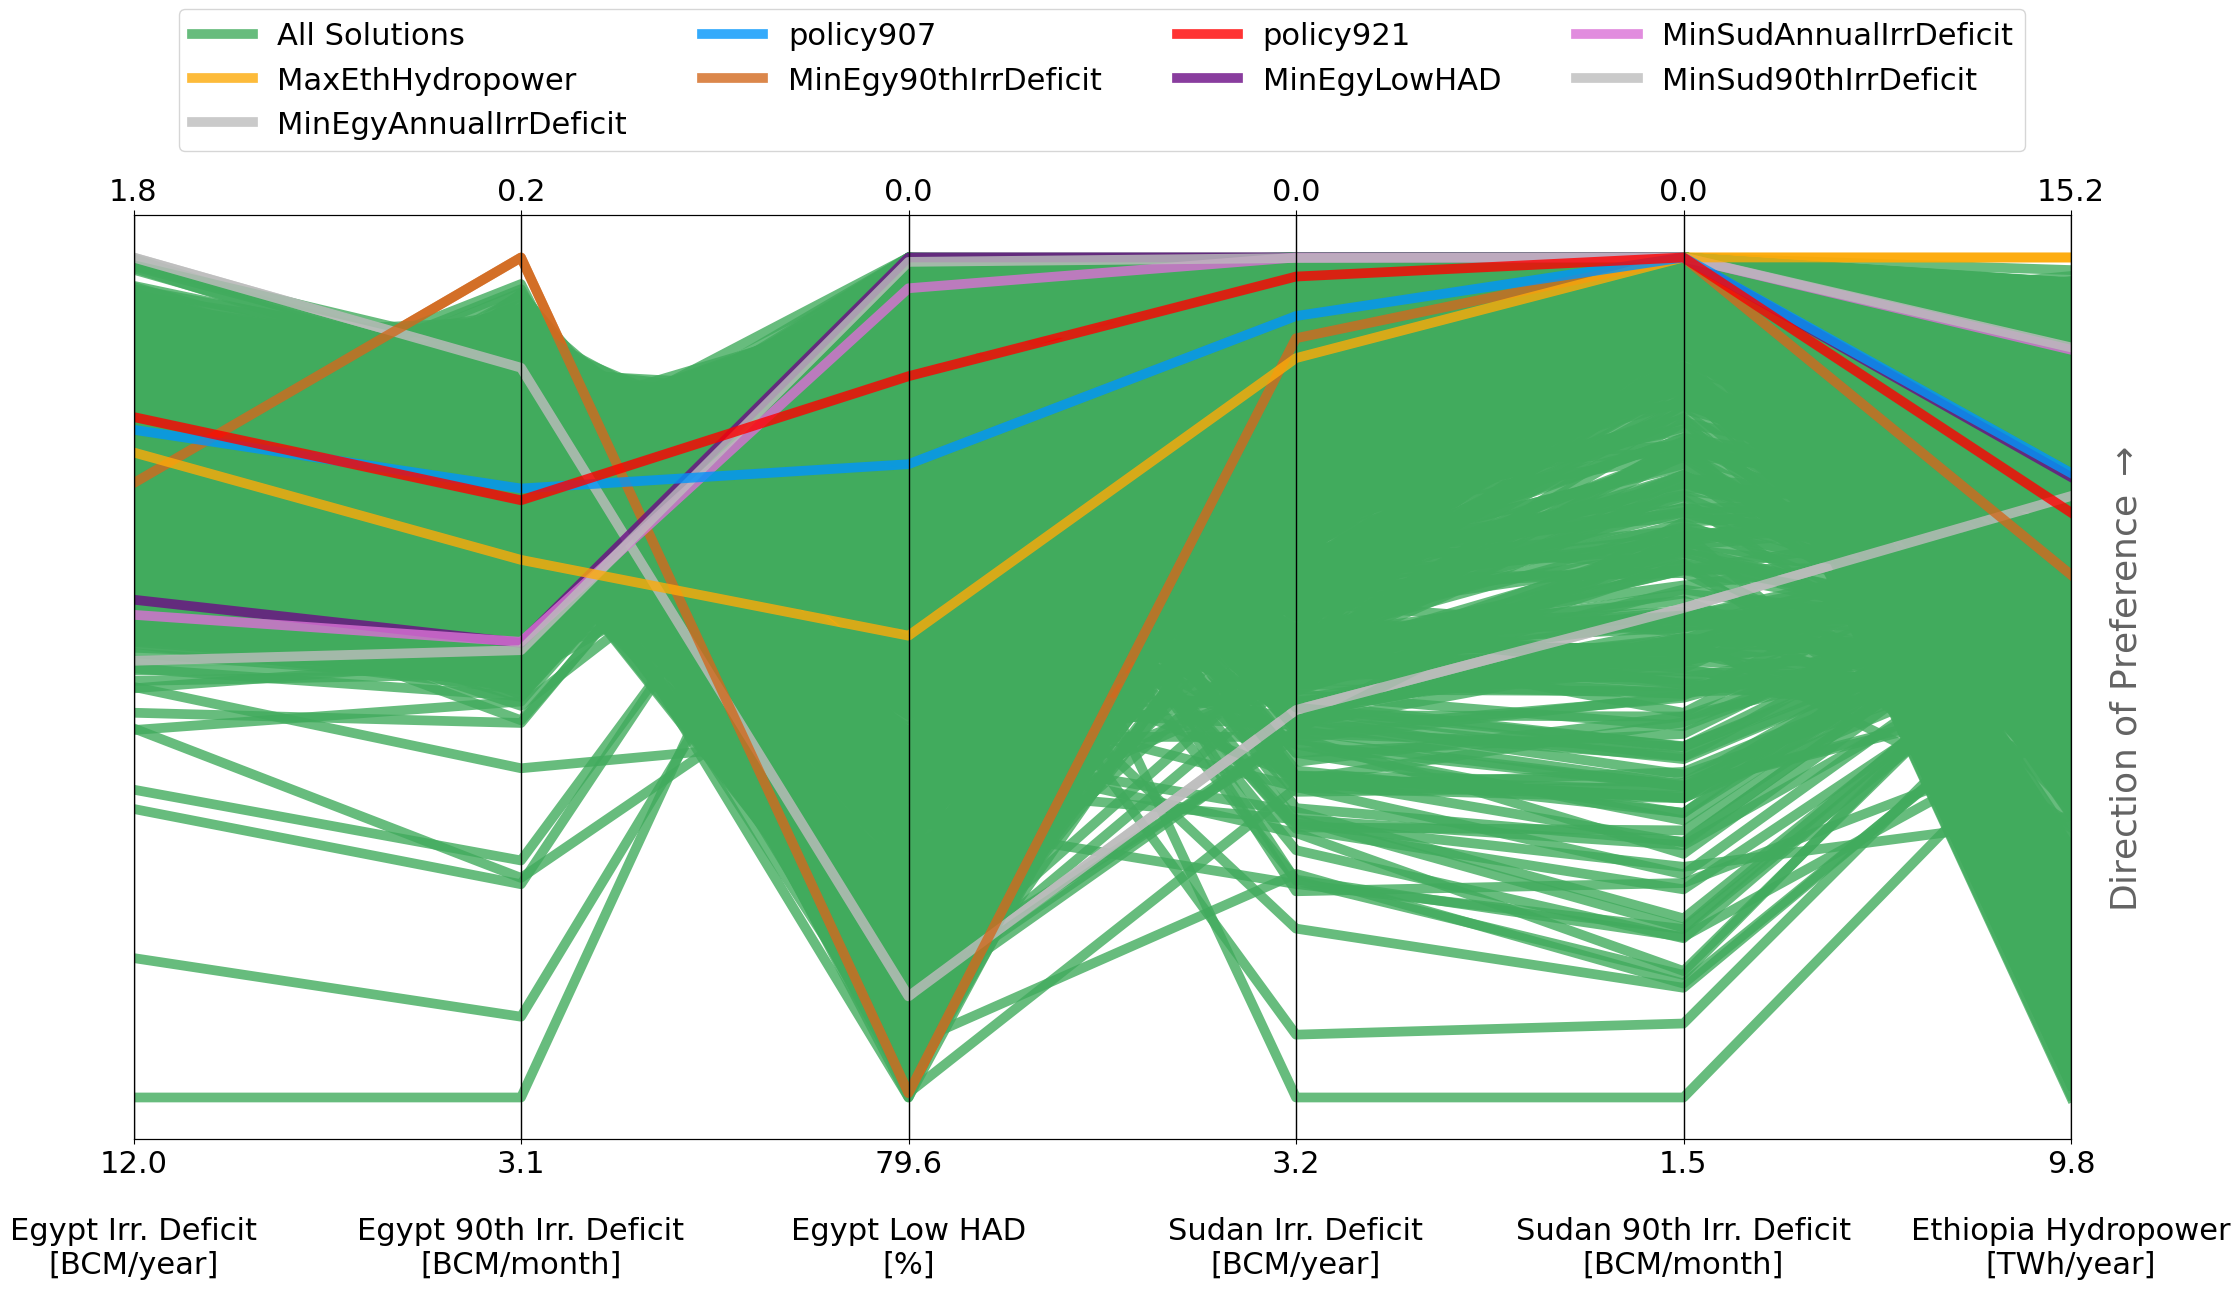

In [28]:
parallel_plots_many_policies(
    objectives,
    solution_indices = paretoset_indices + solution_indices,
    solution_names = paretoset_names + solution_names )

plt.show()

In [29]:
policies_for_exploration = policies.loc[solution_indices, :]
policies_for_exploration["name"] = solution_names
policies_for_exploration.to_csv(
    "water_systems/policies_for_exploration.csv",
    index=False
  )

policies_for_exploration

,v0,v1,v2,v3,v4,v5,v6,v7,v8,v9,...,v155,v156,v157,v158,v159,v160,v161,v162,v163,name
907,0.001934,0.788911,0.473120,0.311130,0.282944,0.787736,-0.576683,0.445035,0.342335,0.007765,...,0.000963,-0.290921,0.094949,0.742236,0.165685,0.210305,0.346039,0.700045,0.741501,policy907
921,0.055398,0.815927,0.409454,0.311287,-0.052417,0.040016,-0.590649,0.428478,0.319171,0.093833,...,0.002073,0.742475,0.901796,0.850134,0.231950,0.733571,0.619399,0.697555,0.864341,policy921


## Defining the states-of-the-world

The idea is to test the Nile sytem model outcomes under a suite of  states-of-the-world (SOWs), this is a fundamental concept in decision analysis which indicates the decision-maker's and modeler's views on uncertainty about the world. In the Nile case, we identify seven uncertain factors that may impact the outcomes of interest.  For each variable, we assume a lower and upper bound described in the following table.

Uncertain Variable| Baseline value | Range|
------------------|----------------|-------------------------|
Annual demand growth rate| 0.0212| 0.01 - 0.03|
Blue Nile mean inflow coefficient| 1 |0.75 - 1.25|
White Nile mean inflow coefficient| 1 |0.75 - 1.25|
Atbara mean inflow coefficient| 1 |0.75 - 1.25|
Blue Nile deviation coefficient| 1 |0.5 - 1.5|
White Nile deviation coefficient| 1 |0.5 - 1.5|
Atbara deviation coefficient| 1 |0.5 - 1.5|

## Experimental design

In order to sample from among all the uncertain variables simultaneously, we will use [Latin Hypercube Sampling (LHS)](https://en.wikipedia.org/wiki/Latin_hypercube_sampling), which is a multi-dimensional sampling technique.
Once we have a candidate set of samples, we will run a simulation for each policy and scenario combination.  We will use the [Exploratory Modelling and Analysis (EMA) Workbench](https://emaworkbench.readthedocs.io/en/latest/.  Run the code below to install and import the required python classes from the ema_workbench.

In [30]:
#!pip install ema_workbench
from ema_workbench import RealParameter, ScalarOutcome, Model, Policy
from ema_workbench import MultiprocessingEvaluator, ema_logging
from ema_workbench.analysis import feature_scoring

## Connecting the EMA Workbench with the Nile Model

The code below connects the Nile model with the EMA workbench.  We first specify the problem, the uncertainties, the policy levers, and the outcomes of interest.

In [31]:
# Generating ModelNile object and connecting it to the EMA Workbench:
nile_model = ModelNile()
em_model = Model("NileProblem", function=nile_model)

# Specifying the uncertainties:
em_model.uncertainties = [
    RealParameter("yearly_demand_growth_rate", 0.01, 0.03),
    RealParameter("blue_nile_mean_coef", 0.75, 1.25),
    RealParameter("white_nile_mean_coef", 0.75, 1.25),
    RealParameter("atbara_mean_coef", 0.75, 1.25),
    RealParameter("blue_nile_dev_coef", 0.5, 1.5),
    RealParameter("white_nile_dev_coef", 0.5, 1.5),
    RealParameter("atbara_dev_coef", 0.5, 1.5),
]

# Now the levers and lever ranges. Note that these correspond to RBF parameters!
parameter_count = nile_model.overarching_policy.get_total_parameter_count()
n_inputs = nile_model.overarching_policy.functions["release"].n_inputs
n_outputs = nile_model.overarching_policy.functions["release"].n_outputs
RBF_count = nile_model.overarching_policy.functions["release"].RBF_count
p_per_RBF = 2 * n_inputs + n_outputs # weights- outputs for each input > center and weights.

lever_list = list()
for i in range(parameter_count):
    modulus = (i - n_outputs) % p_per_RBF #parameters per RBF
    if (
        (i >= n_outputs)
        and (modulus < (p_per_RBF - n_outputs))
        and (modulus % 2 == 0)
    ):  # centers:
        lever_list.append(RealParameter(f"v{i}", -1, 1))
    else:  # linear parameters for each release, radii and weights of RBFs:
        lever_list.append(RealParameter(f"v{i}", 0, 1))

em_model.levers = lever_list

# Specify outcomes of interest:
em_model.outcomes = [
    ScalarOutcome("egypt_irr", ScalarOutcome.MINIMIZE),
    ScalarOutcome("egypt_90", ScalarOutcome.MINIMIZE),
    ScalarOutcome("egypt_low_had", ScalarOutcome.MINIMIZE),
    ScalarOutcome("sudan_irr", ScalarOutcome.MINIMIZE),
    ScalarOutcome("sudan_90", ScalarOutcome.MINIMIZE),
    ScalarOutcome("ethiopia_hydro", ScalarOutcome.MAXIMIZE),
]

## Task 3. Running Simulations for a selected Policy under a wide range on scenarios.

To guarantee good coverage of the uncertainty space, we need to run our simulation under a large set of scenarios.  Your task is to **run 1000 scenarios with a compromise policy** that you selected in Task 3. Keep in mind that each experiment takes around 2 seconds. So,  the expected runtime is approximately 2000 seconds (approximately 34 minutes). You can use the logging function to collect information about the time to completion during the run.

<br>

The function *evaluator.perform_experiments* returns:
1. A dataframe that stores the experiment details (experiments)
2. A dictionary of arrays of objective values (outcomes)

<br>

**Important Note:** Export your experiment outputs to avoid loosing them when the runtime is restarted.

Tip: Start small, that is, perform a few trial runs with a small number of scenarios and policies, make sure that everything runs as you expect, and that you are able to keep track of the simulation outcomes before you launch a larger experiment.

In [37]:
policies.head()


,v0,v1,v2,v3,v4,v5,v6,v7,v8,v9,...,v154,v155,v156,v157,v158,v159,v160,v161,v162,v163
0,0.082993,0.811609,0.463100,0.292359,0.279911,0.848383,-0.595641,0.134243,0.325801,0.030051,...,-0.466434,0.474934,-0.606206,0.840118,0.732148,0.324570,0.598760,0.617328,0.903964,0.063729
1,0.015787,0.809545,0.927957,0.311354,0.286745,0.854163,-0.590347,0.464409,0.317463,0.029033,...,-0.459966,0.001598,0.731373,0.934790,-0.082013,0.217403,0.189810,0.618542,0.269902,0.871519
2,0.082993,0.811609,0.946431,0.292359,0.279911,0.848383,-0.586181,0.134243,0.325801,0.030051,...,-0.466434,0.474934,-0.606206,0.840118,0.732148,0.324570,0.598760,0.617328,0.903964,0.063729
3,0.014471,0.803036,0.949657,0.311288,0.275820,0.848383,-0.627287,0.167977,0.291462,0.100378,...,-0.459819,0.001643,0.272550,0.119956,-0.053885,0.042826,0.183201,0.618279,0.924576,0.141372
4,0.015787,0.869487,0.943521,0.311354,0.286745,0.856220,-0.590347,0.585532,0.317463,0.029033,...,-0.459864,0.001598,0.730829,0.975989,-0.087795,0.688901,0.189810,0.618542,0.270329,0.883693


In [47]:
policy_indices = [907, 921, 1019, 661, 10, 2, 0, 740]  # just an example list of indices
my_policies = policies.loc[policy_indices]

my_policies.head(10)

,v0,v1,v2,v3,v4,v5,v6,v7,v8,v9,...,v154,v155,v156,v157,v158,v159,v160,v161,v162,v163
907,0.001934,0.788911,0.473120,0.311130,0.282944,0.787736,-0.576683,0.445035,0.342335,0.007765,...,-0.460719,0.000963,-0.290921,0.094949,0.742236,0.165685,0.210305,0.346039,0.700045,0.741501
921,0.055398,0.815927,0.409454,0.311287,-0.052417,0.040016,-0.590649,0.428478,0.319171,0.093833,...,-0.459809,0.002073,0.742475,0.901796,0.850134,0.231950,0.733571,0.619399,0.697555,0.864341
1019,0.002770,0.766593,0.250628,0.311287,0.289713,0.827933,-0.589742,0.442659,0.317202,0.027030,...,-0.459909,0.001862,0.758667,0.105407,-0.061780,0.687740,0.186733,0.617508,0.726078,0.066627
661,0.000441,0.723165,0.462111,0.311412,0.499805,0.844433,-0.594726,0.518667,0.320867,0.096151,...,-0.460005,0.374782,0.777399,0.106708,0.709302,0.721887,0.731738,0.642085,0.928486,0.931350
10,0.082993,0.811609,0.953803,0.292042,0.281240,0.848383,-0.585990,0.137080,0.325836,0.086664,...,-0.466179,0.474934,0.636820,0.840506,0.741529,0.741888,0.598760,0.665771,0.903964,0.851327
2,0.082993,0.811609,0.946431,0.292359,0.279911,0.848383,-0.586181,0.134243,0.325801,0.030051,...,-0.466434,0.474934,-0.606206,0.840118,0.732148,0.324570,0.598760,0.617328,0.903964,0.063729
0,0.082993,0.811609,0.463100,0.292359,0.279911,0.848383,-0.595641,0.134243,0.325801,0.030051,...,-0.466434,0.474934,-0.606206,0.840118,0.732148,0.324570,0.598760,0.617328,0.903964,0.063729
740,0.002525,0.200959,0.943539,0.311361,0.298201,0.848421,-0.584362,0.593783,-0.667568,0.028421,...,-0.466534,0.033126,0.775771,0.228104,0.727064,0.766159,0.187258,0.618653,0.702984,0.856284


In [44]:
# Number of scenarios to be sampled from the uncertainty ranges
n_scenarios = 200

# Read the policies we prepared during the lab session
policy_df = pd.read_csv("water_systems/policies_for_exploration.csv")
my_policies = policies.loc[policy_indices]

# Turning on logging to get informed during the run
ema_logging.log_to_stderr(ema_logging.INFO)

with MultiprocessingEvaluator(em_model,7) as evaluator:
    experiments, outcomes = evaluator.perform_experiments(
        n_scenarios, # Integer input means EMA will sample this many scenarios for us
        my_policies # Policy objects as input means it will run the sampled scenarios with each of the policies
    )

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


[MainProcess/INFO] pool started with 7 workers
[MainProcess/INFO] terminating pool


ValueError: The truth value of a DataFrame is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

## Task 4. Global Sensitivity Analysis

In this part, we will examine the sensitivity of the outcomes of interest to  uncertain conditions and to the policy selection. Building on the outcomes generated in Task 3, we will infer variable significance, that is, which factor matters the most for our outcomes of interest.  There are a number of machine learning techniques to generate these insights. EMA Workbench supports [feature scoring](https://emaworkbench.readthedocs.io/en/latest/indepth_tutorial/open-exploration.html#feature-scoring) which is based on fitting multiple regression/classification trees for the relationship between inputs and outputs. **Calculate the feature scores of all uncertain variables as well as the selection of policy on every outcome of interest**. This corresponds to 8 feature score inputs (7 uncertain veriables + 1 column for the policy selection) and 6 feature score outputs (1 for each objective). Think about the arguments you use while calling the functions that calculate feature scores. You can refer to the [GitHub page](https://github.com/quaquel/EMAworkbench/blob/master/ema_workbench/analysis/feature_scoring.py) which contains the feature scoring source code.  **Reflect** on your findings.  Which factors or combination of factors are the most influential for our analysis?  What are the implications for the Nile system?  What are the potential risks and opportunities for the three countries involved?

In [ ]:
experiments.drop(columns=list(model.levers.keys()), inplace=True)

import matplotlib.pyplot as plt

scores = feature_scoring.get_feature_scores_all(experiments, outcomes, mode=RuleInductionType.REGRESSION)
ax = sns.heatmap(scores, annot=False, cmap = "Blues", fmt=".2f")
#ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
#plt.shows()